# Projet Fifa : partie 3

In [153]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import RANSACRegressor
from sklearn.svm import SVC
import importlib
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, AdaBoostRegressor
from imblearn.under_sampling import NearMiss
from sklearn.pipeline import Pipeline
from pickle import load
import joblib

In [2]:
sys.path.append("..")
from fifa import fifa_utils as ffu 
_ = importlib.reload(ffu) #pour reloader en cas de modification

In [3]:
cleaned_data = pd.read_csv("../data/cleaned_data.csv")

In [ ]:
df = cleaned_data.drop(cleaned_data.columns[0], axis=1)

In [5]:
df.head(1)

,sofifa_id,overall,potential,age,club_team_id,league_level,nationality_id,nation_team_id,preferred_foot,weak_foot,...,cb,rcb,rb,gk,player_position,BMI,Dvalue,Dwage,value_eur,wage_eur
0,158023,93,93,30-35,73.0,1.0,52,1369.0,Left,4,...,50,50,61,19,FWD,24.913495,high,high,78000000.0,320000.0


### Dernière étape de cleaning : Gestion des NaN

Cette étape n'a pas été traité dans la partie précédente bien qu'elle aurait dû l'être.  
On cherche à supprimer tous les NaN du dataset, en les remplaçant ou en supprimant les lignes qui en comportent s'il y en a peu.  
On identifie d'abord les colonnes où il y en a :

In [6]:
def show_nans(df):
    cols_with_nan = df.columns[df.isna().sum(axis=0) > 0]
    for col in cols_with_nan:
        print(f"{col} : {df[col].isna().sum(axis=0)} NaN")

In [7]:
show_nans(df)

club_team_id : 61 NaN
league_level : 61 NaN
nation_team_id : 18480 NaN
pace : 2132 NaN
shooting : 2132 NaN
passing : 2132 NaN
dribbling : 2132 NaN
defending : 2132 NaN
physic : 2132 NaN
goalkeeping_speed : 17107 NaN
value_eur : 74 NaN
wage_eur : 61 NaN


In [8]:
nb_goals = df[df["player_position"] == "GK"].shape[0]
nb_no_goals = df.shape[0] - nb_goals
print(f"Il y a {nb_goals} goals et {nb_no_goals} joueurs non goal")

Il y a 2132 goals et 17107 joueurs non goal


En regardant le nombre de NaN pour certaines colonnes et le nombre de goals/non-goals, on remarque que certaines statistiques ne sont pas définies pour les goals et qu'une statistique ("goalkeeeping_speed") n'est pas définie pour les non goals.  
Ainsi, puisque ce sont des attributs flottants, il est peut-être judicieux de remplacer ces NaN par la valeur 0. Il existe un risque pour que cela fausse le modèle, mais puisque cette valeur de 0 sera corrélée à la position du joueur, il est probable que cela ne fasse que dupliquer l'information dans ces cas-ci. On opte donc pour cette option. 

In [9]:
cols_nan_to_zero = ["pace", "shooting", "passing", "dribbling", "defending", "physic", "goalkeeping_speed"]

In [10]:
for col in cols_nan_to_zero:
    df[col] = df[col].fillna(0)

Les NaN restants sont les suivants :

In [11]:
show_nans(df)

club_team_id : 61 NaN
league_level : 61 NaN
nation_team_id : 18480 NaN
value_eur : 74 NaN
wage_eur : 61 NaN


On a bien remplacés les NaN des colonnes visées par des 0.

Ensuite, nous avons plus de 18 000 NaN (sur 19 200 joueurs environ en tout) pour le nation_team_id. De plus, c'est une colonne qui ne nous apporte pas énormément d'information sachant que nous avons la nationalité du joueur et que cela est fortement corrélé avec son équipe nationale. Ainsi, la solution la plus simple sans perdre trop d'information est de retirer cette colonne.

In [12]:
df = df.drop("nation_team_id", axis=1)

In [13]:
show_nans(df)

club_team_id : 61 NaN
league_level : 61 NaN
value_eur : 74 NaN
wage_eur : 61 NaN


Enfin, il reste des NaN pour les valeurs d'id de club qu'on ne peut inférer, comme il y en a peu, on supprime les lignes concernées (61 lignes / 19 239, négligeable). Idem pour league_level.

In [14]:
df = df[df["club_team_id"].notna()]
df = df[df["league_level"].notna()]
df["club_team_id"] = pd.Series(df["club_team_id"], dtype=int)
df["league_level"] = pd.Series(df["league_level"], dtype=int)

On regarde le nombre de NaN restants :

In [15]:
show_nans(df)

value_eur : 13 NaN


Il reste 13 NaN pour les valeurs des joueurs, on remplace par la moyenne des valeurs de tous les joueurs.

In [16]:
df["value_eur"] = df["value_eur"].fillna(df["value_eur"].mean())

In [17]:
show_nans(df)

Il n'y a plus de valeur non renseignée, on peut donc sauvegarder ce dataset qui servira de base à ceux utilisés pour les entraînements. On supprime l'id sofifa des features et on le met en index du dataframe.

In [18]:
df = df.set_index("sofifa_id")
df.to_csv("../data/model_data.csv")

## Importation et préparation à la prédiction

In [72]:
df = pd.read_csv("../data/model_data.csv", index_col=0)

In [73]:
cat_cols = ["age", "preferred_foot", "player_position"]
numcat_cols = ["league_level", "club_team_id", "nationality_id"]
potential_targets = ["value_eur", "wage_eur", "Dwage", "Dvalue"]
num_cols = list( set(df.columns).difference(set(cat_cols)).difference(set(numcat_cols)).difference(set(potential_targets)) )

In [74]:
"  ".join(num_cols)

'movement_agility  mentality_composure  ls  goalkeeping_handling  power_shot_power  power_stamina  rm  cm  defending  goalkeeping_diving  gk  movement_reactions  lb  lcm  rcb  lm  ldm  skill_curve  lcb  mentality_interceptions  goalkeeping_kicking  movement_acceleration  defending_sliding_tackle  power_jumping  movement_sprint_speed  skill_long_passing  skill_fk_accuracy  attacking_heading_accuracy  mentality_penalties  physic  cf  mentality_vision  lf  dribbling  power_long_shots  mentality_positioning  shooting  goalkeeping_positioning  cb  cam  st  power_strength  defending_standing_tackle  overall  lw  skill_dribbling  rb  rdm  ram  goalkeeping_speed  movement_balance  weak_foot  goalkeeping_reflexes  attacking_crossing  attacking_volleys  cdm  attacking_short_passing  rf  skill_moves  rwb  international_reputation  BMI  skill_ball_control  defending_marking_awareness  mentality_aggression  lam  attacking_finishing  lwb  passing  rs  rw  pace  potential  rcm'

Pour prédire les informations concernant les valeurs / salaires, on supprimera les autres colonnes qui font état de ces informations (de manière discrète ou continue).

In [75]:
def category_encode(df):
    code = {"-20":0,
            "20-25":1,
            "25-30":2,
            "30-35":3,
            "+35":4,
            
            "Left":0,
            "Right":1,
            
            "GK":0,
            "DEF":1,
            "MID":2,
            "FWD":3}
    
    for col in cat_cols:
        df.loc[:,col] = df[col].map(code)
    

def create_X_y(df, target_col):
    assert target_col in potential_targets
    X = df.drop(potential_targets, axis=1)
    y = df[target_col]
    return (X, y)

On encode manuellement les catégories en nombres entiers (car il n'y a que 3 colonnes concernées).

In [76]:
category_encode(df)

/tmp/ipykernel_3052/3644165991.py:17: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,col] = df[col].map(code)
/tmp/ipykernel_3052/3644165991.py:17: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,col] = df[col].map(code)
/tmp/ipykernel_3052/3644165991.py:17: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,col] 

In [18]:
df.head(1)

,overall,potential,age,club_team_id,league_level,nationality_id,preferred_foot,weak_foot,skill_moves,international_reputation,...,cb,rcb,rb,gk,player_position,BMI,Dvalue,Dwage,value_eur,wage_eur
sofifa_id,,,,,,,,,,,,,,,,,,,,,
158023,93,93,3,73,1,52,0,4,4,5,...,50,50,61,19,3,24.913495,high,high,78000000.0,320000.0


## 1. Salaire d'un joueur

### 1.a Prédiction de la catégorie de salaire

#### Préparation 

In [6]:
def normalize_train(X_train):
    """
    Normalize numerical columns only in place and return the standard scaler
    """
    scaler = StandardScaler().fit(X_train)
    X_scaled = scaler.transform(X_train)
    X_scaled = pd.DataFrame(X_scaled, columns=X_train.columns, index=X_train.index)
    for col in num_cols:
        X_train[col] = X_scaled[col]
    return scaler

def normalize_test(X_test, scaler):
    """
    Normalize numerical columns only in place using the provided scaler
    """
    X_scaled = scaler.transform(X_test)
    X_scaled = pd.DataFrame(X_scaled, columns=X_test.columns, index=X_test.index)
    for col in num_cols:
        X_test[col] = X_scaled[col]

def plot_class_repartition(y, target_name):
    class_counts = dict(y.value_counts())
    labels = list(class_counts.keys())
    counts = list(class_counts.values())
    plt.figure(figsize=(4,3))
    plt.pie(counts, labels=labels)
    plt.title(f"Répartition des classes de {target_name}")
    plt.show()

def evaluation(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cmatrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=model.classes_)
    disp.plot()
    plt.show()
    print(classification_report(y_test, y_pred, zero_division=0))
    N, train_score, test_score = learning_curve(model, X_train, y_train, cv=5, scoring="f1_weighted", train_sizes=np.linspace(0.1, 1, 10))

    plt.figure(figsize=(6,4))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, test_score.mean(axis=1), label='validation score')
    plt.title("Weighted average f1-score en fonction de la taille du train set")
    plt.legend()
    plt.show()

In [31]:
X, y = create_X_y(df, "Dwage")

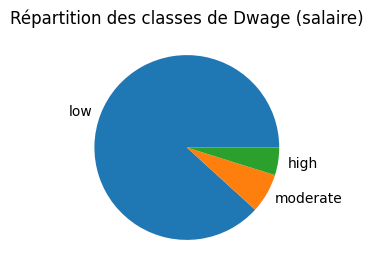

In [32]:
plot_class_repartition(y, "Dwage (salaire)")

On remarque que les classes sont très déséquilibrées, on utilise donc le module imbalanced-learn, extension de scikit-learn.  
On utilise NearMiss pour resampler nos données et avoir un dataset plus équilibré.

In [33]:
nm = NearMiss()
X_b, y_b = nm.fit_resample(X, y)

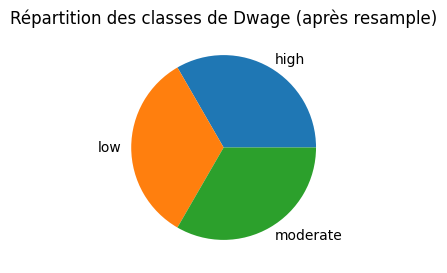

In [34]:
plot_class_repartition(y_b, "Dwage (après resample)")

In [35]:
y_b.shape

(2778,)

In [36]:
y.shape

(19178,)

On a fortement divisé la taille du dataset (presque par 10), mais le NearMiss a gardé les points les plus pertinents dans la plus large classe. On essaye donc de travailler tout de même avec ce dataset réduit. Il faut faire ce choix, ou alors celui de travailler avec un dataset déséquilibré. Ici, nous préférons l'option qui réduit le nombre de points d'exemple.

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_b, y_b, test_size=0.33, random_state=42)
print(y_train.shape, "\n", y_test.shape)

(1861,) 
 (917,)


In [38]:
scaler = normalize_train(X_train)
normalize_test(X_test, scaler)

In [39]:
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

#### Entraînement et Evaluation

In [44]:
models = {"SVC": SVC(random_state=0),
          "RandomForest": RandomForestClassifier(random_state=0),
          "AdaBoost": AdaBoostClassifier(random_state=0)
         }

== SVC ==


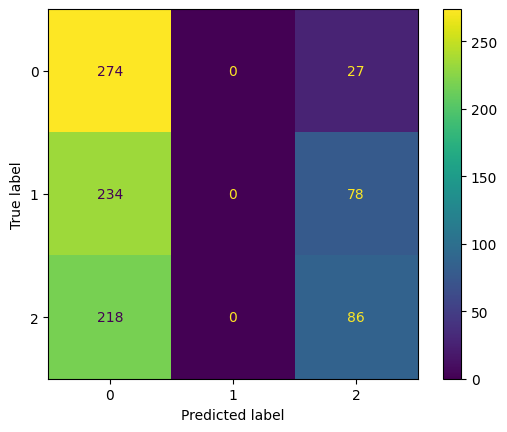

              precision    recall  f1-score   support

           0       0.38      0.91      0.53       301
           1       0.00      0.00      0.00       312
           2       0.45      0.28      0.35       304

    accuracy                           0.39       917
   macro avg       0.28      0.40      0.29       917
weighted avg       0.27      0.39      0.29       917



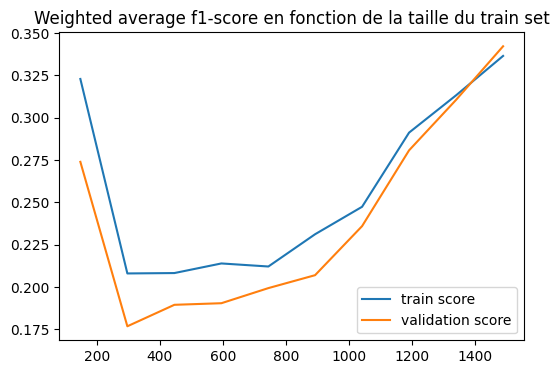

== RandomForest ==


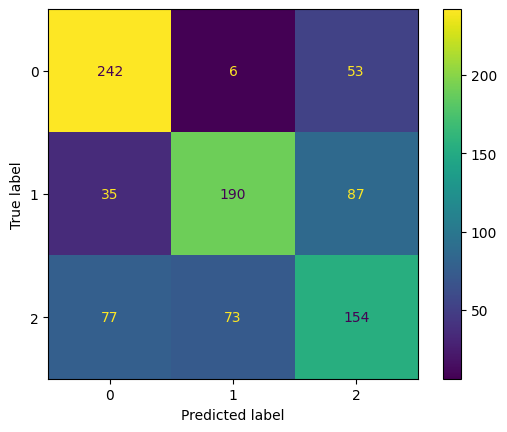

              precision    recall  f1-score   support

           0       0.68      0.80      0.74       301
           1       0.71      0.61      0.65       312
           2       0.52      0.51      0.52       304

    accuracy                           0.64       917
   macro avg       0.64      0.64      0.64       917
weighted avg       0.64      0.64      0.64       917



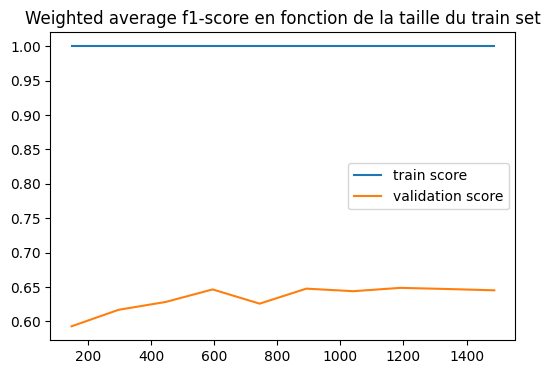

== AdaBoost ==


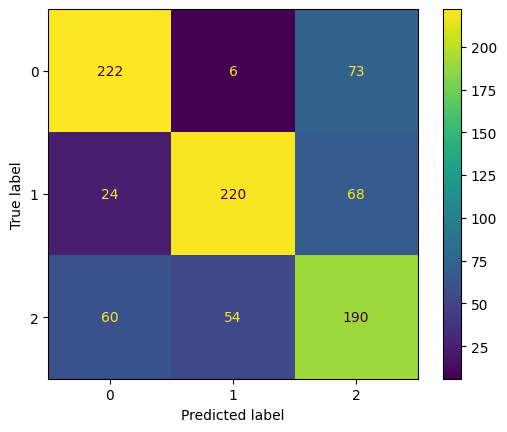

              precision    recall  f1-score   support

           0       0.73      0.74      0.73       301
           1       0.79      0.71      0.74       312
           2       0.57      0.62      0.60       304

    accuracy                           0.69       917
   macro avg       0.70      0.69      0.69       917
weighted avg       0.70      0.69      0.69       917



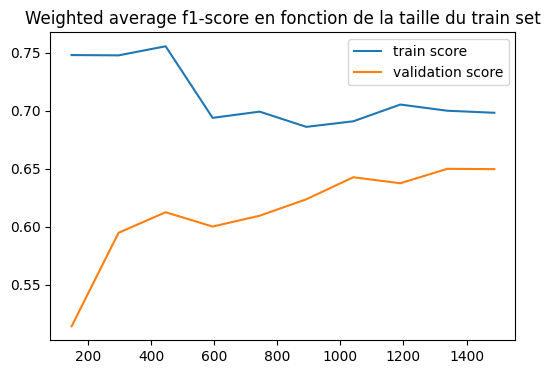

In [45]:
for name in models:
    print(f"== {name} ==")
    evaluation(models[name], X_train, X_test, y_train, y_test)

INTERPRETATIONS :  
**SVC :** Nous avons testé ce modèle car il s'agit d'un classique pour une tâche de classification comme celle-ci.  
Cependant, le modèle est très inefficace pour notre tâche, où alors il nécessite des hyperparamètres plus adaptés.  
Il fait beaucoup d'erreurs et prédit en majorité la classe 0 (d'où le bon rappel pour cette classe), jamais la classe 1, et parfois la classe 2, mais pas majoritairement quand il le faut.  
Le classifieur semble donner des résultats naïfs, et ne fait pas beaucoup mieux que le hasard (accuracy de 0.39).  
Ce modèle ne semble pas adapté.

**Random Forest Classifier :** Le choix de la random forest s'explique par son efficacité due à la sagesse des foules (ou plutôt des forêts ici). En effet, nous avons de meilleurs résultats et nous prédisons en majorité la bonne classe pour chacune d'entre elle. Cependant, il existe tout de même un certain nombre d'erreurs qui sont commises, et ceci pour les trois classes. L'accuracy est tout même quasiment le double du modèle précédent. Ce qui augure du bon pour la suite concernant ce modèle.  
Les courbes d'apprentissage nous montrent que le modèle overfitte beaucoup, ce qui est souvent le cas pour une random forest avec peu de données. En effet, la courbe de train reste à 1, tandis que la courbe de test peine à augmenter.  

**AdaBoost :** C'est pour ce modèle que les résultats sont les meilleurs, nous prédisons la bonne classe en majorité et il y a moins d'hésitations pour ce modèle sauf pour la classe 2. L'accuracy est quasiment de 0.7, les f1-scores sont tous au dessus de 0.6 (le pire étant pour la classe 2 comme évoqué).  
Les courbes d'apprentissage ont une allure très satisfaisant, le modèle overfitte de moins en moins et augmente sa qualité de prédiction à mesure qu'on augmente le train set. Il faudrait donc idéalement plus de données pour améliorer encore les performances. Autrement, on pourrait chercher à trouver les meilleurs hyperparamètres, c'est ce que nous allons faire dans la suite.

Il est important de relever le biais majeur qui est que nous avons peu de données dans cette partie de classification, puisque nous avons équilibré le dataset et qu'il y avait une classe extrêmement majoritaire. Ce problème ne se rencontrera pas dans la partie régression. Toutefois, malgré ce faible nombre de données, la learning curve d'Adaboost (avec paramètres par défaut) semble plutôt satisfaisante, même si le score doit évidemment être augmenté.


#### Optimisation

On va essayer ici d'optimiser d'avantage l' AdaBoost, via un RandomSearch.

In [52]:
hyperparams = {"n_estimators" : np.linspace(50, 500, 10, dtype=int),
               "learning_rate" : np.geomspace(0.1, 100, 10),
               "algorithm" : ["SAMME", "SAMME.R"]
              }

In [59]:
adaboost = AdaBoostClassifier()
rs = RandomizedSearchCV(adaboost, hyperparams, n_iter=50, cv=4, random_state=42, verbose=2, n_jobs=2)

In [ ]:
search = rs.fit(X_train, y_train)

In [61]:
search.best_params_

{'n_estimators': 450, 'learning_rate': 1.0, 'algorithm': 'SAMME'}

In [62]:
better_ab = AdaBoostClassifier(n_estimators=450, learning_rate=1, algorithm="SAMME")

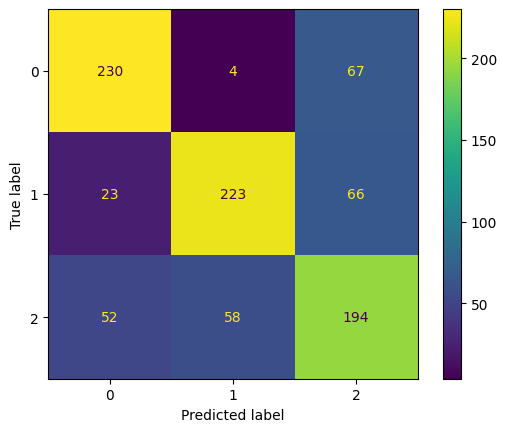

              precision    recall  f1-score   support

           0       0.75      0.76      0.76       301
           1       0.78      0.71      0.75       312
           2       0.59      0.64      0.61       304

    accuracy                           0.71       917
   macro avg       0.71      0.71      0.71       917
weighted avg       0.71      0.71      0.71       917



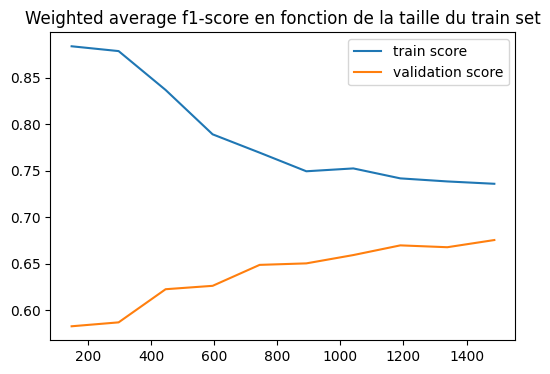

In [63]:
better_ab.fit(X_train, y_train)
evaluation(better_ab, X_train, X_test, y_train, y_test)

Avec l'optimisation d'AdaBoost via le RandomSearch, nous avons légèrement augmenté les performances du modèle. Au prix d'un temps de calcul plus long. Nos métriques ont gagné quelques points, notamment l'accuracy est passée de 0.69 à 0.71.  
On pourrait encore augmenter ces performances en raffinant d'avantage la recherche des meilleurs hyperparamètres, mais aussi à l'étape du préprocessing en ne gardant que des features décorellées.  
De plus, il s'agit peut-être également d'un tâche délicate dont nous ne pouvons tirer des scores excellent (au-delà de 0.8, 0.9).

### 1.b Prédiction de la valeur du salaire

Nous faisons face à une tâche de régression cette fois. Nous n'avons donc pas à tenir compte de l'équilibre des classes et pouvons donc utiliser l'intégralité du dataset.

In [103]:
X, y = create_X_y(df, "wage_eur")

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
scaler = normalize_train(X_train)
normalize_test(X_test, scaler)

In [15]:
X_train.head(2)

,overall,potential,age,club_team_id,league_level,nationality_id,preferred_foot,weak_foot,skill_moves,international_reputation,...,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_position,BMI
sofifa_id,,,,,,,,,,,,,,,,,,,,,
222346,0.175733,-0.676034,2,111724,1,155,1,-1.410579,-0.464747,-0.255495,...,0.660276,0.490157,0.745316,0.976635,0.976635,0.976635,0.745316,-0.083199,1,1.223950
241687,-1.134091,-1.168858,1,1586,1,25,0,-1.410579,-0.464747,-0.255495,...,0.014754,0.129445,0.176767,0.235865,0.235865,0.235865,0.176767,-0.479526,1,-0.885602


In [16]:
X_test.head(2)

,overall,potential,age,club_team_id,league_level,nationality_id,preferred_foot,weak_foot,skill_moves,international_reputation,...,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_position,BMI
sofifa_id,,,,,,,,,,,,,,,,,,,,,
260681,-2.007306,-1.168858,1,111928,1,117,1,-1.410579,-0.464747,-0.255495,...,-0.200421,-0.231267,-0.178576,-0.235535,-0.235535,-0.235535,-0.178576,-0.479526,2,-0.840692
240942,0.321269,0.802439,1,472,2,45,1,0.075404,-0.464747,-0.255495,...,0.947175,0.706585,0.745316,0.909292,0.909292,0.909292,0.745316,-0.479526,2,-0.359193


In [17]:
models = {"RANSAC": RANSACRegressor(random_state=0),
          "RandomForest": RandomForestRegressor(random_state=0),
          "AdaBoost": AdaBoostRegressor(n_estimators=500, random_state=0)
         }

In [32]:
def evaluation_reg(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f" MSE = {mean_squared_error(y_test, y_pred)}")
    print(f" MAE = {mean_absolute_error(y_test, y_pred)}")
    print(f" Coefficient R² = {r2_score(y_test, y_pred)}\n")

In [99]:
for name in models:
    print(f"== {name} ==")
    evaluation_reg(models[name], X_train, X_test, y_train, y_test)

== RANSAC ==
 MSE = 484725335.5809108
 MAE = 9044.310229942492
 Coefficient R² = -0.20226813796408716

== RandomForest ==
 MSE = 484412020.71728647
 MAE = 9041.306688260389
 Coefficient R² = -0.20149102059465007

== AdaBoost ==
 MSE = 484361267.0315042
 MAE = 9029.583619744679
 Coefficient R² = -0.20136513582069426



Les résultats sont très mauvais, pour tous les modèles, on garde le RANSAC et on rajoute des features polynomiales, mais d'abord, il est nécessaire de diminuer la volumétrie des features, on ne va garder que les features numériques décorrellées (extraites dans la partie 1) avec les catégorielles (encodées).

In [33]:
with open("../../partie-1-2/data/decorr_features.bin", "rb") as file:
    decorr_num_cols = load(file)

In [34]:
len(decorr_num_cols)

32

In [35]:
" ".join(decorr_num_cols)

'mentality_penalties attacking_heading_accuracy skill_moves mentality_aggression power_stamina BMI skill_long_passing physic goalkeeping_positioning overall attacking_crossing movement_reactions goalkeeping_kicking mentality_composure gk skill_curve potential goalkeeping_diving power_shot_power goalkeeping_reflexes attacking_volleys goalkeeping_handling power_strength movement_agility rwb movement_balance weak_foot power_jumping attacking_finishing pace skill_fk_accuracy lf'

In [104]:
for col in num_cols:
    if col not in decorr_num_cols:
         X = X.drop(col, axis=1)

In [105]:
X.shape

(19178, 38)

In [142]:
def normalize_train_decorr(X_train):
    """
    Normalize decorrelated numerical columns only in place and return the standard scaler
    """
    scaler = StandardScaler().fit(X_train)
    X_scaled = scaler.transform(X_train)
    X_scaled = pd.DataFrame(X_scaled, columns=X_train.columns, index=X_train.index)
    for col in decorr_num_cols:
        X_train[col] = X_scaled[col]
    return scaler

def normalize_test_decorr(X_test, scaler):
    """
    Normalize decorrelated numerical columns only in place using the provided scaler
    """
    X_scaled = scaler.transform(X_test)
    X_scaled = pd.DataFrame(X_scaled, columns=X_test.columns, index=X_test.index)
    for col in decorr_num_cols:
        X_test[col] = X_scaled[col]

def normalize_target(y_train):
    scaler = StandardScaler().fit(y_train.to_numpy().reshape(-1,1))
    y_train = scaler.transform(y_train.to_numpy().reshape(-1,1))
    return y_train[:,0], scaler

def normalize_target_test(y_test, scaler):
    y_test = scaler.transform(y_test.to_numpy().reshape(-1,1))
    return y_test[:,0]

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
scaler = normalize_train_decorr(X_train)
normalize_test_decorr(X_test, scaler)
y_train, yscaler = normalize_target(y_train)
y_test = normalize_target_test(y_test, yscaler)

In [147]:
pipe = Pipeline(steps=[
    ('preprocessor', PolynomialFeatures(degree=2)),
    ('estimator', RANSACRegressor(random_state=0))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', PolynomialFeatures()),
                ('estimator', RANSACRegressor(random_state=0))])

In [149]:
y_pred = pipe.predict(X_test)
print(r2_score(y_test, y_pred))

-15.60658485379313


In [150]:
pipe = Pipeline(steps=[
    ('preprocessor', PolynomialFeatures(degree=2)),
    ('estimator', RandomForestRegressor(random_state=0))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', PolynomialFeatures()),
                ('estimator', RandomForestRegressor(random_state=0))])

In [152]:
y_pred = pipe.predict(X_test)
print(r2_score(y_test, y_pred))

0.815255007799976


In [154]:
joblib.dump(pipe, "model_1b.joblib")

['model_1b.joblib']

Les résultats de régression sont beaucoup mieux et très satisfaisant en utilisant uniquement les features décorellées et le degré 2 et une Random Forest de 100 arbres. Un R2 de 0.81 est très bien pour notre tâche, surtout vu le score obtenu par le RANSAC simple.

## 2. Valeur d'un joueur

### 2.a Prédiction de la catégorie de valeur

In [19]:
X, y = create_X_y(df, "Dvalue")

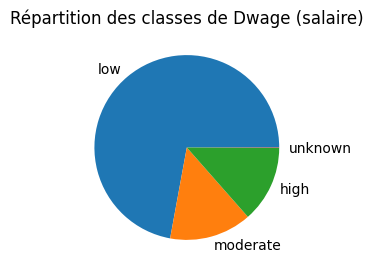

In [20]:
plot_class_repartition(y, "Dwage (salaire)")

On suprime les lignes de la classe "unknown".

In [24]:
df.shape

(19178, 84)

In [26]:
df = df[df["Dvalue"] != "unknown"]

In [27]:
df.shape

(19165, 84)

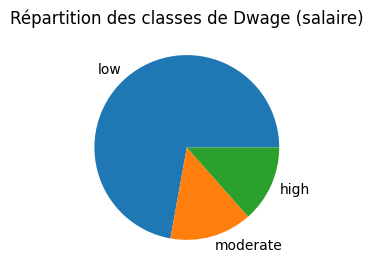

In [28]:
X, y = create_X_y(df, "Dvalue")
plot_class_repartition(y, "Dwage (salaire)")

In [29]:
nm = NearMiss()
X_b, y_b = nm.fit_resample(X, y)

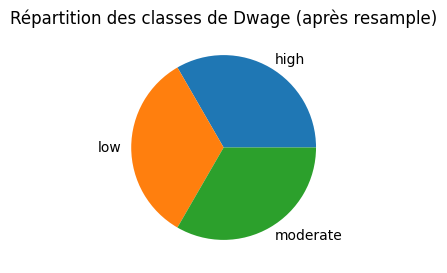

In [30]:
plot_class_repartition(y_b, "Dwage (après resample)")

In [31]:
y_b.shape

(7731,)

In [32]:
y.shape

(19165,)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_b, y_b, test_size=0.33, random_state=42)
print(y_train.shape, "\n", y_test.shape)

(5179,) 
 (2552,)


In [34]:
scaler = normalize_train(X_train)
normalize_test(X_test, scaler)

In [35]:
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

#### Entraînement et Evaluation

In [42]:
models = {"SVC": SVC(random_state=0),
          "RandomForest": RandomForestClassifier(random_state=0),
          "AdaBoost": AdaBoostClassifier(random_state=0)
         }

== SVC ==


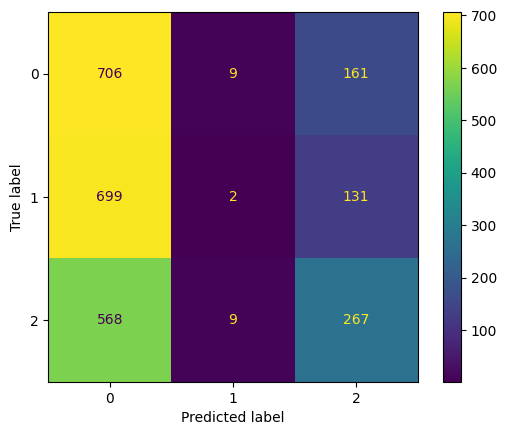

              precision    recall  f1-score   support

           0       0.36      0.81      0.50       876
           1       0.10      0.00      0.00       832
           2       0.48      0.32      0.38       844

    accuracy                           0.38      2552
   macro avg       0.31      0.37      0.29      2552
weighted avg       0.31      0.38      0.30      2552



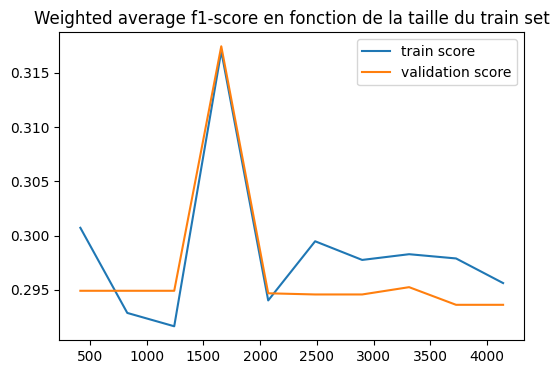

== RandomForest ==


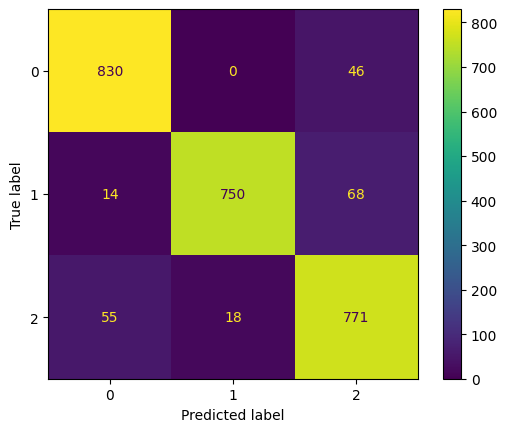

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       876
           1       0.98      0.90      0.94       832
           2       0.87      0.91      0.89       844

    accuracy                           0.92      2552
   macro avg       0.92      0.92      0.92      2552
weighted avg       0.92      0.92      0.92      2552



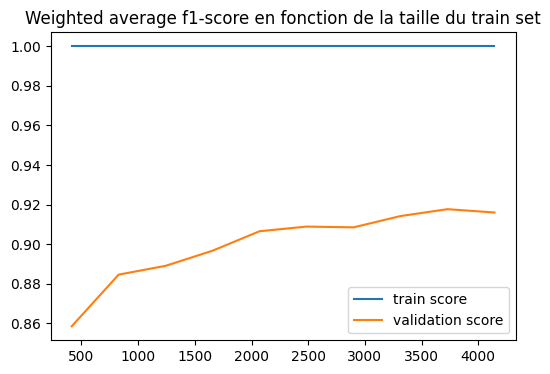

== AdaBoost ==


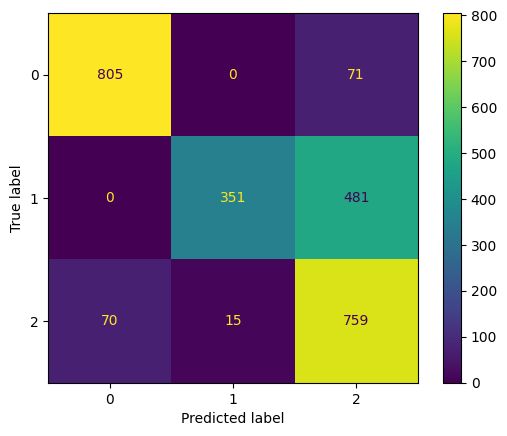

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       876
           1       0.96      0.42      0.59       832
           2       0.58      0.90      0.70       844

    accuracy                           0.75      2552
   macro avg       0.82      0.75      0.74      2552
weighted avg       0.82      0.75      0.74      2552



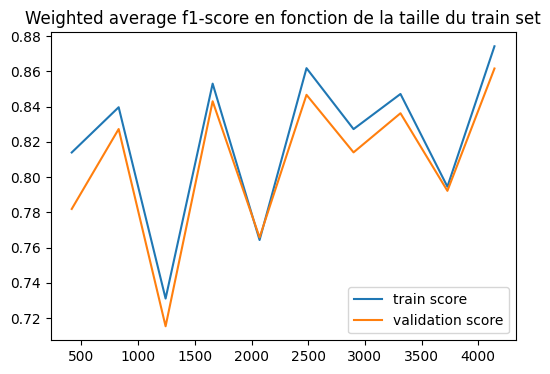

In [43]:
for name in models:
    print(f"== {name} ==")
    evaluation(models[name], X_train, X_test, y_train, y_test)

INTERPRETATIONS :  
**SVC :** Mêmes remarques que pour la prédiction de la catégorie de salaire, excepté que les résultats sont légèrement meilleurs.

**Random Forest Classifier :** Ce modèle est très performant pour la prédiction de catégorie de valeur, beaucoup plus que pour le salaire. On atteint un f1-score très satisfaisant pour toutes les classes, la matrice de confusion nous montre visuellement très rapidement que ce modèle fait de l'excellent travail.  
L'accuracy est de 0.86, ce qui est très bien pour un modèle avec les hyperparamètres par défaut. On pourrait chercher à augmenter encore ce score par optimisation, mais on ne le fera pas ici. La courbe d'apprentissage est très satisfaisante (la random forest overfit beaucoup mais c'est un attendu pour ce type de modèle, avec ce nombre de données).

**AdaBoost :** Le modèle est moins efficace que pour la prédiction de salaire, et le modèle de Random Forest permet d'obtenir de meilleurs résultats. Dans ce dernier, on a peu de confusion entre classes alors qu'ici on voit que le f-score est inférieur pour les trois classes. Le modèle fait plus de confusions : notamment, il prédit régulièrement à tort la classe 2 au lieu de la classe 1. La courbe d'apprentissage semble erratique contrairement à l'étude de classification précédente.

Pour la prédiction de valeur, on peut donc se tourner vers un modèle de Random Forest, qu'on pourrait éventuellement optimiser d'avantage.


### 2.b Prédiction de la valeur

Tout comme en partie 1.b, il semble judicieux de réduire la dimensionalité de notre dataset pour améliorer les performances et les résultats de notre modèle. On va ne garder que les features catégorielles et numériques décorrelées.

In [157]:
X, y = create_X_y(df, "value_eur")

In [158]:
for col in num_cols:
    if col not in decorr_num_cols:
         X = X.drop(col, axis=1)

In [159]:
X = X.drop(["club_team_id", "nationality_id"], axis=1)

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
scaler = normalize_train_decorr(X_train)
normalize_test_decorr(X_test, scaler)
y_train, yscaler = normalize_target(y_train)
y_test = normalize_target_test(y_test, yscaler)

In [166]:
pipe = Pipeline(steps=[
    ('preprocessor', PolynomialFeatures(degree=2)),
    ('estimator', RANSACRegressor(random_state=0))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', PolynomialFeatures()),
                ('estimator', RANSACRegressor(random_state=0))])

In [167]:
y_pred = pipe.predict(X_test)
print(r2_score(y_test, y_pred))

-5.079955421093522


In [168]:
pipe = Pipeline(steps=[
    ('preprocessor', PolynomialFeatures(degree=2)),
    ('estimator', RandomForestRegressor(random_state=0))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', PolynomialFeatures()),
                ('estimator', RandomForestRegressor(random_state=0))])

In [170]:
y_pred = pipe.predict(X_test)
print(r2_score(y_test, y_pred))

0.9474168392102332


Les résultats sont très très bons pour le régresseur Random Forest dans la prédiction de la valeur des joueurs (R² de 0.947). Il semble donc possible de prédire efficacement cette quantité à partir des attributs décorrellés que nous avons gardé.

In [172]:
joblib.dump(pipe, "model_2b.joblib")

['model_2b.joblib']

## 3. Caractéristiques des joueur internationaux vs. joueurs français

Est-ce que ce qui rend un joueur cher rend un français cher ?  

Pour répondre à cette question, on prend le modèle de la partie 2.b qui prédit la valeur d'un joueur (entraîné sur un certain nombre de joueurs de différentes nationalités), et on entraîne un modèle similaire entraîné uniquement sur les joueurs français. Ensuite, on compare les prédictions sur les joueurs de test.

In [194]:
X, y = create_X_y(df, "value_eur")

In [195]:
for col in num_cols:
    if col not in decorr_num_cols:
         X = X.drop(col, axis=1)

X = X.drop(["club_team_id"], axis=1)

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)


In [197]:
X_train = X_train[X_train["nationality_id"] == 18] #on ne garde que des joueurs français dans le train set
y_train = y_train.loc[X_train.index]

In [201]:
X_train = X_train.drop("nationality_id", axis=1)
X_test = X_test.drop("nationality_id", axis=1)

In [202]:
scaler = normalize_train_decorr(X_train)
normalize_test_decorr(X_test, scaler)
y_train, yscaler = normalize_target(y_train)
y_test = normalize_target_test(y_test, yscaler)

In [207]:
model_fr = Pipeline(steps=[
    ('preprocessor', PolynomialFeatures(degree=2)),
    ('estimator', RandomForestRegressor(random_state=0))
])

model_fr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', PolynomialFeatures()),
                ('estimator', RandomForestRegressor(random_state=0))])

In [208]:
model_world = joblib.load("model_2b.joblib")

In [209]:
y_pred_fr = model_fr.predict(X_test)
y_pred_world = model_world.predict(X_test)

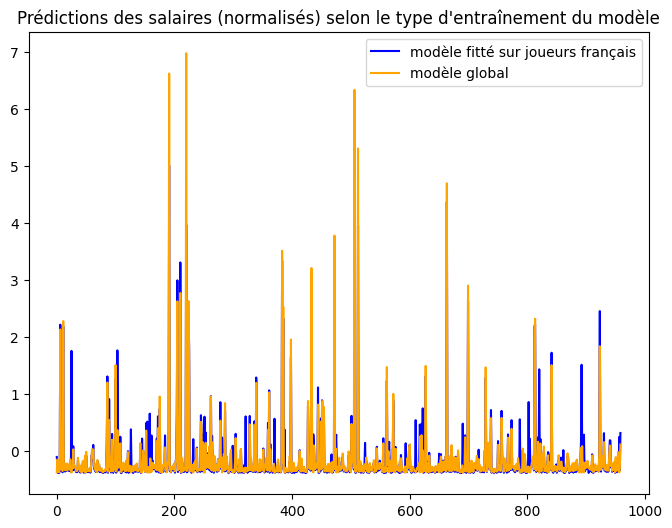

In [210]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(y_test.shape[0]), y_pred_fr, color="blue", label="modèle fitté sur joueurs français")
plt.plot(np.arange(y_test.shape[0]), y_pred_world, color="orange", label="modèle global")
plt.title("Prédictions des salaires (normalisés) selon le type d'entraînement du modèle")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


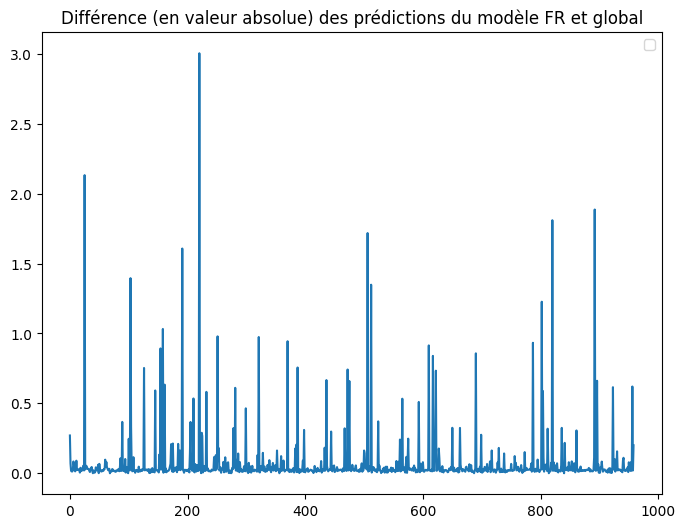

In [211]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(y_test.shape[0]), np.abs(y_pred_fr - y_pred_world))
plt.title("Différence (en valeur absolue) des prédictions du modèle FR et global")
plt.legend()
plt.show()

On remarque qu'il y a des écarts assez importants pour certains éléments du jeu de test, il y a donc a priori des critères qui varient pour estimer qu'un joueur international est cher, et qu'un joueur français l'est. Cependant, on a aussi beaucoup d'exemples où l'écart est faible en terme de prédiction pour les deux modèles. Il y a donc tout de même de nombreuses caractéristiques communes pour estimer qu'un joueur a de la valeur, indépendamment de sa nationalité française.  

Il est bon de notifier un biais majeur : dans le cas du modèle fitté sur les joueurs français, il y a beaucoup moins d'exemples (1000 donc 10 fois moins) que pour l'entraînement de l'autre modèle. Ce qui le rend beaucoup moins précis dans ce qu'il cherche à approximer (i.e. la fonction réelle qui estime la valeur d'un français).

## 4. Sélection par rapport à un faible nombre d'attributs

Un décideur vous dit qu’il ne sélectionne les joueurs que par rapport à Overall
Ratings, Wage, International Reputation, Weak Foot et Skill Moves. Que pouvez-vous
lui dire par rapport à vos différents tests de prédiction ?  

Pour répondre à cette question, nous allons entraîner un modèle (du type de celui en 2b) pour prédire la valeur d'un joueur, mais entraîné uniquement avec les features citées ci-dessus.

In [213]:
" ".join(list(df.columns))

'overall potential age club_team_id league_level nationality_id preferred_foot weak_foot skill_moves international_reputation pace shooting passing dribbling defending physic attacking_crossing attacking_finishing attacking_heading_accuracy attacking_short_passing attacking_volleys skill_dribbling skill_curve skill_fk_accuracy skill_long_passing skill_ball_control movement_acceleration movement_sprint_speed movement_agility movement_reactions movement_balance power_shot_power power_jumping power_stamina power_strength power_long_shots mentality_aggression mentality_interceptions mentality_positioning mentality_vision mentality_penalties mentality_composure defending_marking_awareness defending_standing_tackle defending_sliding_tackle goalkeeping_diving goalkeeping_handling goalkeeping_kicking goalkeeping_positioning goalkeeping_reflexes goalkeeping_speed ls st rs lw lf cf rf rw lam cam ram lm lcm cm rcm rm lwb ldm cdm rdm rwb lb lcb cb rcb rb gk player_position BMI Dvalue Dwage value_e

In [214]:
def create_X_y_p4(df):
    kept_cols = ["overall", "wage_eur", "international_reputation", "weak_foot", "skill_moves"]
    X = df[kept_cols]
    y = df["value_eur"]
    return (X, y)

In [215]:
X, y = create_X_y_p4(df)

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [226]:
Xscaler = StandardScaler().fit(X_train)
X_train = Xscaler.transform(X_train)
X_test = Xscaler.transform(X_test)

yscaler = StandardScaler().fit(y_train.to_numpy().reshape(-1,1))
y_train = yscaler.transform(y_train.to_numpy().reshape(-1,1))[:,0]
y_test = yscaler.transform(y_test.to_numpy().reshape(-1,1))[:,0]

In [232]:
model_4 = Pipeline(steps=[
    ('preprocessor', PolynomialFeatures(degree=2)),
    ('estimator', RandomForestRegressor(random_state=0))
])

model_4.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', PolynomialFeatures()),
                ('estimator', RandomForestRegressor(random_state=0))])

In [233]:
y_pred = model_4.predict(X_test)
print(r2_score(y_test, y_pred))

0.8297702572246931


En n'utilisant que ces 5 attributs, nous arrivons tout de même à avoir un coefficient R² de 0.83. Ce qui est une très bonne performance.  
Ce test semble donc montrer que l'utilisation seule de ces 5 attributs peut suffire à estimer de manière correcte la valeur d'un joueur. Cependant, pour gagner en précision, il est préférable d'utiliser d'autres features comme la trentaine utilisée précédemment avec le modèle en 2.b qui a permis d'atteindre un R² de presque 0.95.  

C'est en tout cas un très bon choix de features si l'on devait n'en choisir que très peu.  
Il existe tout de même le biais de corrélation très probable entre le salaire et la valeur (cf. partie 1 et 2 de l'étude) : le salaire doit aider fortement à l'estimation de la valeur.

### 